# Предсказание оттока клиентов оператора связи
Оператору связи необходимо научиться прогнозировать отток клиентов. 
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## План выполнения проекта:
### <a href=#1>1. Анализ данных</a>

### <a href=#2>2. Подготовка данных</a>
-    ####  <a href=#2_1> 2.1 Кодирование признаков</a>
-    ####  <a href=#2_2> 2.2 Приведение к необходимому формату данных</a>
-    ####  <a href=#2_3> 2.3 Подготовка итоговой таблицы</a>
-    ####  <a href=#2_4> 2.4 Подготовка тестовой и тренировочной выборок</a>

### <a href=#3>3. Модель</a>
-    ####  <a href=#3_1> 3.1 Подбор модели</a>
-    ####  <a href=#3_2> 3.2 Обучение и оценка качества моделей</a>

# <a id='1'> 1. Анализ данных</a> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics

In [2]:
contract = pd.read_csv('final_provider/contract.csv')
personal = pd.read_csv('final_provider/personal.csv')
internet = pd.read_csv('final_provider/internet.csv')
phone = pd.read_csv('final_provider/phone.csv')

In [3]:
datas = {'contract' : contract,
         'personal' : personal,
         'internet' : internet,
         'phone' : phone}

In [4]:
#таблица с долей пропусков
def percent_nan(data):
    isna_data = pd.DataFrame(data.isna().sum())
    isna_data.columns = ['nan']
    isna_data['rate'] = isna_data['nan']/len(data)
    return(isna_data.style.format("{:.2%}", subset='rate'))

In [5]:
def get_df_info(df):
    display(df.head(5))
    display(df.info())
    display(df.describe())
    display(percent_nan(df))

In [6]:
for key in datas.keys():
    print('Информация о таблице:', key)
    get_df_info(datas[key])

Информация о таблице: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,nan,rate
customerID,0,0.00%
BeginDate,0,0.00%
EndDate,0,0.00%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,0,0.00%


Информация о таблице: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,nan,rate
customerID,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%
Partner,0,0.00%
Dependents,0,0.00%


Информация о таблице: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7136-RVDTZ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,nan,rate
customerID,0,0.00%
InternetService,0,0.00%
OnlineSecurity,0,0.00%
OnlineBackup,0,0.00%
DeviceProtection,0,0.00%
TechSupport,0,0.00%
StreamingTV,0,0.00%
StreamingMovies,0,0.00%


Информация о таблице: phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2400-FEQME,No
freq,1,3390


,nan,rate
customerID,0,0.00%
MultipleLines,0,0.00%


**Выводы:**
- В таблице **`contract`** В столбце `PaperlessBilling` содержится бинарный признак. Его необходимо привести к виду **[0, 1]**
- В столбце `TotalCharges` количественный признак в формате **object**. Его необходимо перевести в формат **float64**
- В столбцах `BeginDate` и `EndDate` содержатся даты. Их необходимо перевести в формат даты.
- Из столбцов `BeginDate` и `EndDate` необходимо сгенерировать признак показывающий продолжительность использования услуг оператора.


- В таблице **`personal`** данные в столбцах `gender`, `Partner`, `Dependents` также, необходимо привести к виду **[0,1]**
- Можно перименовать столбец `gender` в `Gender` для сохранения единого вида столбцов.


- В таблицах **`internet`** и **`phone`** все признаки (помимо ID клиента) бинарные. Имеет смысл их также привести к виду **[0, 1]**

Проанализируем данные в таблице **`contract`**

In [7]:
contract['customerID'].value_counts(sort=True, ascending=False).head(5)

7136-RVDTZ    1
2758-RNWXS    1
9237-HQITU    1
1768-HNVGJ    1
0060-FUALY    1
Name: customerID, dtype: int64

В таблице **`contract`** все клиенты числятся в единственном экземпляре. Можно ли утверждать что клиенты не заключают контракт повторно, а просто продлевают действующий? 

In [8]:
contract['TotalCharges'].value_counts().head(5)

         11
20.2     11
19.75     9
20.05     8
19.65     8
Name: TotalCharges, dtype: int64

In [9]:
contract.query('TotalCharges == " "')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Пропуски в столбце `TotalCharges`, скорее всего, говорят о том что пользователь только что заключил договор и итоговая сумма ещё не набежала.

# <a id='2'> Подготовка данных</a> 

## <a id='2_1'>2.1 Кодирование признаков</a> 

Преобразуем данные в необходимые форматы. Закодируем бинарные признаки. 

In [10]:
#функция для кодирования бинарных признаков
def binary_encoding(data, column, bi_dict):
    return(data[column].map(bi_dict))

In [11]:
#список колонок с бинарными признаками вида [Yes, No]
bi_columns_contract = ['PaperlessBilling']
bi_columns_personal = ['Partner', 'Dependents']
bi_columns_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies']

yes_no_dict = {'Yes': 1, 'No': 0}

In [12]:
dfs = [contract, personal, internet]
col_list = [bi_columns_contract, bi_columns_personal, bi_columns_internet]

In [13]:
#цикл для кодирования бинарных признаков во всех таблицах (не знаю на сколько это оптимальный вариант)
for df, col in zip(dfs, col_list):
    for column in col:
        df[column] = binary_encoding(df, column, yes_no_dict)

In [14]:
#кодирования бинарных признаков другого вида
phone['MultipleLines'] = binary_encoding(phone, 'MultipleLines', {'Yes': 2, 'No': 1})
personal['gender'] = binary_encoding(personal, 'gender', {'Female': 0, 'Male': 1})
internet['InternetService'] = binary_encoding(internet, 'InternetService', {'DSL': 1, 'Fiber optic': 2})

In [15]:
#кодирование категориального признака
def leb_enc(data, column):
    lenc = LabelEncoder()
    return lenc.fit_transform(data[column])

In [16]:
contract['PaymentMethod'] = leb_enc(contract, 'PaymentMethod')
contract['Type'] = leb_enc(contract, 'Type')

## <a id='2_2'>2.2 Приведение к необходимому формату данных</a> 

Приведение значений столбцов к необходимым форматам:
- **`contract`** `TotalCharges` - **float64**
- **`contract`** `BeginDate` и `EndDate` - **datetime**

In [17]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], downcast='float', errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d', errors='coerce')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

In [18]:
for key in datas.keys():
    print('Информация о таблице:', key)
    display(datas[key].head(5))
    display(percent_nan(datas[key]))

Информация о таблице: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,NaT,0,1,2,29.85,29.850000
1,5575-GNVDE,2017-04-01,NaT,1,0,3,56.95,1889.500000
2,3668-QPYBK,2019-10-01,2019-12-01,0,1,3,53.85,108.150002
3,7795-CFOCW,2016-05-01,NaT,1,0,0,42.30,1840.750000
4,9237-HQITU,2019-09-01,2019-11-01,0,1,2,70.70,151.649994


,nan,rate
customerID,0,0.00%
BeginDate,0,0.00%
EndDate,5174,73.46%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,11,0.16%


Информация о таблице: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


,nan,rate
customerID,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%
Partner,0,0.00%
Dependents,0,0.00%


Информация о таблице: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,1,0,0,0,0
1,5575-GNVDE,1,1,0,1,0,0,0
2,3668-QPYBK,1,1,1,0,0,0,0
3,7795-CFOCW,1,1,0,1,1,0,0
4,9237-HQITU,2,0,0,0,0,0,0


,nan,rate
customerID,0,0.00%
InternetService,0,0.00%
OnlineSecurity,0,0.00%
OnlineBackup,0,0.00%
DeviceProtection,0,0.00%
TechSupport,0,0.00%
StreamingTV,0,0.00%
StreamingMovies,0,0.00%


Информация о таблице: phone


,customerID,MultipleLines
0,5575-GNVDE,1
1,3668-QPYBK,1
2,9237-HQITU,1
3,9305-CDSKC,2
4,1452-KIOVK,2


,nan,rate
customerID,0,0.00%
MultipleLines,0,0.00%


Сгенерируем новый признак. Используем даты начала договора, даты окончания договора и дату сбора данных для определения времени пользования услугой в днях.

In [19]:
END_DAY = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
def get_life_time(data):
    begin_date = data['BeginDate']
    end_date = data['EndDate']
    
    def diff_days(d1, d2):
        return (d1 - d2).days
#        return (d1.year - d2.year) * 12 + d1.month - d2.month
        
    
    if end_date is pd.NaT:
        
        life_time = diff_days(END_DAY, begin_date)
    else:
        life_time = diff_days(end_date, begin_date)
    return life_time

In [20]:
contract['LifeTime'] = contract.apply(get_life_time, axis=1)

In [21]:
#нормализация данных для линейной модели
def normal_feature(train_data, test_data):
    scaler = StandardScaler()
    scaler.fit(train_data)
    return scaler.transform(test_data)

## <a id='2_3'> 2.3 Подготовка итоговой таблицы</a> 

In [22]:
#бинаризация целевого признака
contract['EndDate'] = np.where(contract['EndDate'].isna(), 1, 0)

In [23]:
data = contract.set_index('customerID').join(personal
                                             .set_index('customerID')).join(internet
                                                                            .set_index('customerID').join(phone.set_index('customerID'), how='outer'))

In [24]:
get_df_info(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,1,0,1,2,29.85,29.850000,31,0,0,1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN
5575-GNVDE,2017-04-01,1,1,0,3,56.95,1889.500000,1036,1,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3668-QPYBK,2019-10-01,0,0,1,3,53.85,108.150002,61,1,0,0,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7795-CFOCW,2016-05-01,1,1,0,0,42.30,1840.750000,1371,1,0,0,0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN
9237-HQITU,2019-09-01,0,0,1,2,70.70,151.649994,61,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null int32
Type                7043 non-null int32
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null int32
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float32
LifeTime            7043 non-null int64
gender              7043 non-null int64
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
InternetService     5517 non-null float64
OnlineSecurity      5517 non-null float64
OnlineBackup        5517 non-null float64
DeviceProtection    5517 non-null float64
TechSupport         5517 non-null float64
StreamingTV         5517 non-null float64
StreamingMovies     5517 non-null float64
MultipleLines       6361 non-null float64
dtypes: datetime64[ns](1), float32(1), float64(9), int

None

,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,6361.000000
mean,0.734630,0.690473,0.592219,1.574329,64.761692,2283.300537,985.996166,0.504756,0.162147,0.483033,0.299588,1.561175,0.365960,0.440276,0.439007,0.370491,0.490665,0.495197,1.467065
std,0.441561,0.833755,0.491457,1.068104,30.090047,2266.771484,747.587844,0.500013,0.368612,0.499748,0.458110,0.496289,0.481742,0.496465,0.496311,0.482980,0.499958,0.500022,0.498953
min,0.000000,0.000000,0.000000,0.000000,18.250000,18.799999,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,35.500000,401.450012,273.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475098,883.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,2.000000,89.850000,3794.737549,1676.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,2.000000,1.000000,3.000000,118.750000,8684.799805,2191.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


,nan,rate
BeginDate,0,0.00%
EndDate,0,0.00%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,11,0.16%
LifeTime,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%


Заменим все пропуски на значения 0 так как, в случае с услугами, это и будет означать отстутвие подключения к услуге, а в случае с признаком TotalCharges будет означать количество набежавшей суммы.

In [25]:
data = data.fillna(0)
percent_nan(data)

,nan,rate
BeginDate,0,0.00%
EndDate,0,0.00%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,0,0.00%
LifeTime,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%


Посмотрим на корреляцию признаков в итоговой таблице:

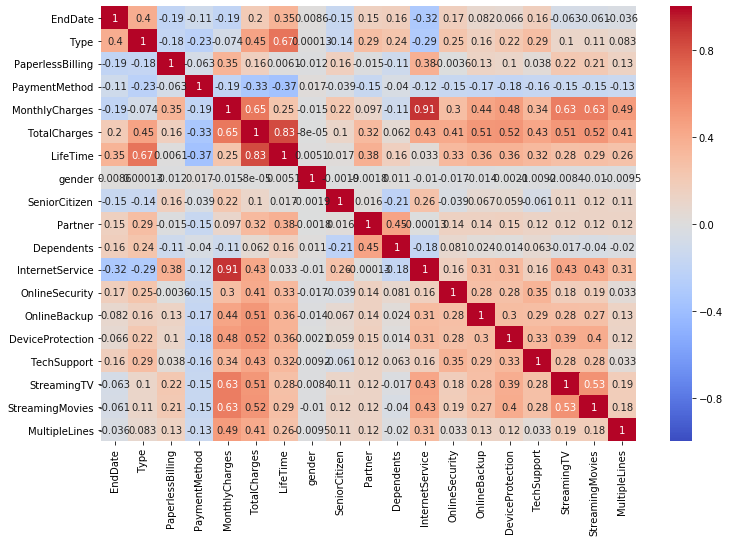

In [26]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)

Из таблицы коррелиции признаков видно:
- `InternetService` и `MonthlyCharges` имею очень высокую корреляцию **0.91**. Первый признак указывает на то подключина ли услуга интернета и какой тип подключения используется. Вероятно, цена на эти услуги имеет заметную градацию, что влияет на цену в месяц. Один из этих признаков необходимо убрать из выборки.
- `LifeTime` и `TotalCharges` имеют корреляцию **0.83**. Это было предсказуемо. Чем дольше клиент пользуется услугами оператора, тем больше итоговая сумма за всё время использования. Удалим признак `TotalCharges`

Посмотрим баланс классов в выборке:

In [27]:
data['EndDate'].value_counts()

1    5174
0    1869
Name: EndDate, dtype: int64

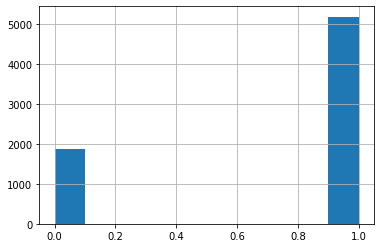

In [28]:
data['EndDate'].hist()

По графику заметно, что объектов класса 1 почти в 3 раза больше чем объектов класса 0. Для более эффективного обучения можно использовать параметр class_weight='balanced', который добавляет веса пропорционально соотношению классов.

## <a id='2_4'> 2.4 Подготовка тестовой и тренировочной выборок</a> 

Отберём признаки для обучения моделей на основе исследования данных из предыдущего пункта.

In [29]:
feature = data.drop(labels=['EndDate', 'BeginDate', 'TotalCharges', 'InternetService'], axis=1)
target = data['EndDate']

Используем модель RandomForest для определние важности признаков:

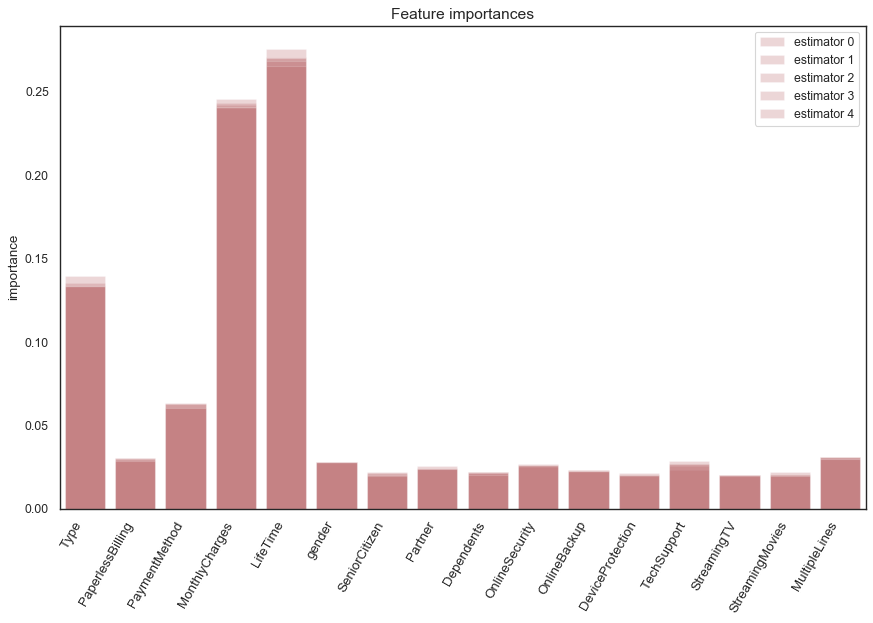

In [30]:
model = RandomForestClassifier(random_state=124, n_estimators=100, class_weight='balanced')
output = cross_validate(model, feature, target, cv=5, scoring = 'accuracy', return_estimator =True)

sns.set(style="white", palette="deep", color_codes=True)
fig, ax = plt.subplots(figsize=(13,8), dpi= 80)
plt.title('Feature importances', fontdict={'fontsize':14})
for idx,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
        feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = feature.columns,
                                        columns=['importance'])
        ax=sns.barplot(x=feature_importances.index, 
                       y='importance', 
                       color='r', 
                       data=feature_importances, 
                       alpha=.25, 
                       label='estimator '+str(idx))
plt.legend()
plt.xticks( rotation=60, horizontalalignment='right', fontsize=12)
plt.show()

In [31]:
feature_importances.sort_values('importance', ascending=False)

,importance
LifeTime,0.270008
MonthlyCharges,0.240630
Type,0.133538
PaymentMethod,0.063295
PaperlessBilling,0.030524
MultipleLines,0.029713
TechSupport,0.028417
gender,0.027845
OnlineSecurity,0.026303
Partner,0.024196


По графику хорошо заметно, что признаки имеющие наибольшее значение это: 
- `LifeTime`
- `MonthlyCharges`
- `Type`
- `PaymentMethod`

Попробуем оставить только эти признаки.

In [32]:
feature = feature.loc[:, ['LifeTime', 
                          'MonthlyCharges', 
                          'Type', 
                          'PaymentMethod']]

In [33]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, 
                                                                          target, 
                                                                          test_size=0.25, 
                                                                          random_state=124)

In [34]:
#нормализуем значения признаков
feature_train_scale = normal_feature(feature_train, feature_train)
feature_test_scale = normal_feature(feature_train, feature_test)

# <a id='3'> 3. Модель</a> 

## <a id='3_1'> 3.1 Подбор модели</a>

In [35]:
#метрика для расчёта roc-auc с помощью кросвалидации
my_scorer = metrics.make_scorer(metrics.roc_auc_score, needs_proba=True)

In [36]:
#ф-ция для расчёта метрик качества
def get_score(model, X_train, y_train):
    clf = model.fit(X_train, y_train)
    res = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)
    accuracy = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print('AUC-ROC_score: {:.2f}'.format(np.mean(res)))
    print('Accuracy_score: {:.2%}'.format(np.mean(accuracy)))
    return np.mean(res), np.mean(accuracy)

In [37]:
#ф-ция для подбора гиперпараметров
def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring='accuracy', cv = 5,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Best Params: ', search.best_params_)

In [38]:

accuracy = [] #метрика качества
auc_roc = []
models = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'LGBMClassifier']

In [39]:
model = RandomForestClassifier(random_state=124, class_weight='balanced')
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(50, 200, 50)}
get_best_params(feature_train, target_train, model, parameters)


Best Params:  {'n_estimators': 50, 'max_depth': 10}


In [40]:
model = GradientBoostingClassifier(random_state=124)
parameters ={'max_depth':np.arange(1, 11),
             'n_estimators':np.arange(50, 200, 50), 
             'learning_rate':np.arange(0.01, 1, 0.05)}
get_best_params(feature_train, target_train, model, parameters)


Best Params:  {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.66}


In [41]:
model = LGBMClassifier(random_state=124, class_weight='balanced')
parameters ={'num_leaves':np.arange(30, 50, 5),
             'max_depth':np.arange(1, 11),
             'n_estimators':np.arange(50, 200, 50), 
             'learning_rate':np.arange(0.01, 1, 0.05)}
get_best_params(feature_train, target_train, model, parameters)


Best Params:  {'num_leaves': 30, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.6100000000000001}


## <a id='3_2'> 3.2 Обучение и оценка качества моделей</a>

In [42]:
#Логистическая регрессия 
log_reg = LogisticRegression(penalty='l2', solver='lbfgs')
roc_auc, accur = get_score(log_reg, feature_train_scale, target_train)
auc_roc.append(roc_auc)
accuracy.append(accur)

AUC-ROC_score: 0.82
Accuracy_score: 78.57%


In [43]:
rfc = RandomForestClassifier(random_state=124, n_estimators=50, max_depth=10, class_weight='balanced')
roc_auc, accur = get_score(rfc, feature, target)
auc_roc.append(roc_auc)
accuracy.append(accur)

AUC-ROC_score: 0.86
Accuracy_score: 78.62%


In [44]:
gbc = GradientBoostingClassifier(random_state=124, n_estimators=100, max_depth=3, learning_rate=0.66)
roc_auc, accur = get_score(gbc, feature, target)
auc_roc.append(roc_auc)
accuracy.append(accur)

AUC-ROC_score: 0.92
Accuracy_score: 87.52%


In [45]:
lgbmc = LGBMClassifier(boosting_type='dart', random_state= 124, 
                       class_weight='balanced', 
                       num_leaves= 35, 
                       n_estimators= 150, 
                       max_depth= 10, 
                       learning_rate= 0.61)
roc_auc, accur = get_score(lgbmc, feature, target)
auc_roc.append(roc_auc)
accuracy.append(accur)

AUC-ROC_score: 0.91
Accuracy_score: 85.02%


In [46]:
models_score = pd.DataFrame(auc_roc, index=models, columns=['AUC-ROC'])
models_score['Accuracy']=accuracy
models_score

,AUC-ROC,Accuracy
LogisticRegression,0.821678,0.785684
RandomForestClassifier,0.862517,0.786171
GradientBoostingClassifier,0.921937,0.875195
LGBMClassifier,0.910004,0.850206


In [47]:
gb_model = GradientBoostingClassifier(random_state=124, n_estimators=100, max_depth=3, learning_rate=0.66)
gb_model.fit(feature_train, target_train)
predict_prob = gb_model.predict_proba(feature_test)
predict = gb_model.predict(feature_test)
roc_auc = metrics.roc_auc_score(target_test, predict_prob[:, 1])
accuracy = metrics.accuracy_score(target_test, predict)
print('AUC-ROC_score: {:.4f}'.format(roc_auc))
print('Accuracy_score: {:.2%}'.format(accuracy))

AUC-ROC_score: 0.9198
Accuracy_score: 87.05%


Почему бы не состакать модельки...

In [48]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, feature_train, target_train, feature_test):
        X = np.array(feature_train)
        y = np.array(target_train)
        T = np.array(feature_test)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=124).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]

                print ("Fit %s fold %d" % (str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)

                y_pred = clf.predict_proba(X_holdout)[:,1]

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=5, scoring=my_scorer)
        print("Stacker score: %.5f" % (results.mean()))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [49]:
log_model = LogisticRegression(penalty='l2', solver='lbfgs')
gb_model = GradientBoostingClassifier(random_state=124, n_estimators=100, max_depth=3, learning_rate=0.66)
rf_model = RandomForestClassifier(random_state=124, n_estimators=50, max_depth=10, class_weight='balanced')

In [50]:
stack = Ensemble(n_splits=5,
            stacker = log_model,
            base_models = (gb_model, rf_model))

y_pred = stack.fit_predict(feature_train, target_train, feature_test)

Fit GradientBoostingClassifier fold 1
Fit GradientBoostingClassifier fold 2
Fit GradientBoostingClassifier fold 3
Fit GradientBoostingClassifier fold 4
Fit GradientBoostingClassifier fold 5
Fit RandomForestClassifier fold 1
Fit RandomForestClassifier fold 2
Fit RandomForestClassifier fold 3
Fit RandomForestClassifier fold 4
Fit RandomForestClassifier fold 5
Stacker score: 0.90910


In [51]:
roc_auc = metrics.roc_auc_score(target_test, y_pred)
print('AUC-ROC_score: {:.4f}'.format(roc_auc))

AUC-ROC_score: 0.9268


### Вывод:
В процессе выполнения работы я придерживалась первоначального плана. Были внесены незначительные изменения:
- При кодировании бинарных признаков `MultipleLines` и `InternetService` использовались значения 1 и 2. Что в итоговой таблице, при заполнении пропусков нулями, дало дополнительную информацию о наличии подключения услуг телефонной связи и интернета. 
- Из столбцов `BeginDate` и `EndDate` был сгенерирован признак показывающий продолжительность использования услуг оператора.*(Первоначальный вариант, в котором этот признак вычислялся как кол-во месяцев, оказался не очень удачным. Значения AUC-ROC не превышало 0.84. При замене на кол-во дней качество резко улучшилось. Может ли это быть как-то связано с не одинаковым кол-вом дней в месяцах?)*
- При подготовки итоговой таблицы был произведён отбор признаков. Признаки имеющие высокий коэффициент корреляции между собой, были выброшены из выборки. В итоговом датасете остались только столбцы имеющее наибольшее влияние на target. Важность признаков определялась с помощью **feature_importances_**.
- При выборе лучшей модели были рассмотрены Логистическая регрессия (для неё признаки были нормированны) и ансамбли деревьев(**RandomForestClassifier**, **GradientBoostingClassifier**, **LGBMClassifier**).

Самое высокое значение метрик (помимо стакинга моделей)оказалось у модели **GradientBoostingClassifier**:
- AUC-ROC_score: **0.9196**
- Accuracy_score: **87.39%**

Признаки, имеющие наибольшее влияние на целевой признак:
- `LifeTime` - как долго клиент пользуется услугами оператора
- `MonthlyCharges` - помесячная оплата услуг
- `Type` - вид оплаты (помесячно или за несколкьо лет сразу)
- `PaymentMethod` - способ оплаты счёта
